# 承接 104.04 CLV 計算的前半部資料清整程式，下半段融入 RFM 模型
### Rundown: <br>
一、前半段程式  <br>
二、依客戶 ID Groupby 並建立 RFM 欄位 <br>
三、計算 CLV <br>
四、探討欲區分之客戶類型數量 <br>
五、為資料給定 RMF 組別落點 <br>
六、探討對於各類型客戶之經營策略 <br>

### 一、前半段程式

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False

df_onliret = pd.read_csv('OnlineRetail.csv', encoding= 'unicode_escape', thousands = ',', parse_dates = ['InvoiceDate'])  #讀取資料
df_onliret.head()  #檢視資料表頭，確認是 8 欄位資料沒錯。

### 二、資料清整

#檢視資料各屬性，看是否需調整或刪減；並可於刪減資料後、運算資料前，再次處理資料型態，因此時可能因為資料刪減，而使得資料內容更好被辨認是否為所需資料
df_onliret.info()

#CustomerID 性質應該是屬於不可運算的 string，故進行調整：
df_onliret.CustomerID = df_onliret.CustomerID.astype(str)
df_onliret.info()

#留下需要的欄位即可：#0,3,4,5,6，可使用 7 來檢視是否需進一步鎖定特定國家的客戶群進行計算（假設流失狀況會因國家而不同）
df_onliret.Country.describe()

#發現顧客來自於 38 個國家，進一步檢視資料分佈，看是否選擇特定國家就好？
b = df_onliret.Country.value_counts()
b

#求得第一名國家為 UK，進一步了解占比，已更確認資料集中狀況：
for i in b:
    c = i / 541909
    print(f'{c:.2f}')

#UK 占比 91%，在假設不同國家可能有不同購物習性，而有不同流失率的狀況下，決定此次僅使用最大宗的 UK 資料，故刪除其他資料
df_onliret = df_onliret[df_onliret.Country == 'United Kingdom']
df_onliret
#驗證：刪除後列數等於前面計算出來的 UK 資料列數，故並未出現前端資料輸入字串多帶空格等問題

#檢視其他欄位是否存在異常資料
df_onliret.describe().round()
#發現 Quantity 和 UniPrice 有負值，調閱資料了解詳情，是否可能為退貨等因素？

#依貨物負值數量大小看前 20 名，是否有異常
df_onliret[df_onliret['Quantity'] < 0]['Quantity'].value_counts().sort_index().head(20)  
#看似無異常

#依被退次數最多之貨物數量多寡檢視前 20 名，看是否有異常
df_onliret[df_onliret['Quantity'] < 0]['Quantity'].value_counts().sort_values(ascending = False).head(20)
#看似無異常

#依樣檢視 UnitPrice
df_onliret[df_onliret['UnitPrice'] <= 0]['UnitPrice'].value_counts().sort_index(ascending = True).head(20)  
#發現有負值和 0 二類資訊，預計檢視負值之資料列，而 0 之資料列則因數量眾多，判斷為正常狀況，擬不予特別檢視

#檢視 UnitPrice 負值所在整列資訊
df_onliret[df_onliret['UnitPrice'] < 0]
#發現是為了調整壞帳所入之交易紀錄，但可能為往年資料，所以未直接抵銷在資料集中的特定客戶交易資料，故也無對應 CumstomerID。判斷與欲使用資料無關連，故予以刪除：

df_onliret = df_onliret[df_onliret['UnitPrice'] >= 0]
df_onliret

### 3. 計算 CLV

#首先因資料集缺乏每次交易金額合計欄位，故予以計算
c = df_onliret['UnitPrice'] * df_onliret['Quantity']
df_onliret = df_onliret.assign( Total_Purchase = c)
df_onliret

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object       

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total_Purchase
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
541889,581585,22466,FAIRY TALE COTTAGE NIGHT LIGHT,12,2011-12-09 12:31:00,1.95,15804.0,United Kingdom,23.40
541890,581586,22061,LARGE CAKE STAND HANGING STRAWBERY,8,2011-12-09 12:49:00,2.95,13113.0,United Kingdom,23.60
541891,581586,23275,SET OF 3 HANGING OWLS OLLIE BEAK,24,2011-12-09 12:49:00,1.25,13113.0,United Kingdom,30.00
541892,581586,21217,RED RETROSPOT ROUND CAKE TINS,24,2011-12-09 12:49:00,8.95,13113.0,United Kingdom,214.80


### 二、依客戶 ID Groupby 並建立 RFM 欄位

In [2]:
#新增一欄位，讓 goupby 以後的時間可以分別求出最近一次交易日與來往期間長度二欄位
t1 = df_onliret.InvoiceDate
df_onliret = df_onliret.assign(Intervals = t1)
df_onliret

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total_Purchase,Intervals
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12-01 08:26:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01 08:26:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12-01 08:26:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01 08:26:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01 08:26:00
...,...,...,...,...,...,...,...,...,...,...
541889,581585,22466,FAIRY TALE COTTAGE NIGHT LIGHT,12,2011-12-09 12:31:00,1.95,15804.0,United Kingdom,23.40,2011-12-09 12:31:00
541890,581586,22061,LARGE CAKE STAND HANGING STRAWBERY,8,2011-12-09 12:49:00,2.95,13113.0,United Kingdom,23.60,2011-12-09 12:49:00
541891,581586,23275,SET OF 3 HANGING OWLS OLLIE BEAK,24,2011-12-09 12:49:00,1.25,13113.0,United Kingdom,30.00,2011-12-09 12:49:00
541892,581586,21217,RED RETROSPOT ROUND CAKE TINS,24,2011-12-09 12:49:00,8.95,13113.0,United Kingdom,214.80,2011-12-09 12:49:00


In [3]:
#依照客戶 ID 做 groupby，依計算 CLV 及 RFM 需求，後方須分別產生交易次數(F)、總購買金額(M)，及最近一次交易日(R)
now = df_onliret.InvoiceDate.max()  #不須轉換成 Date 形式，只需保留跟原 InvoiceDate 欄位一致的 datetime 形式，就可在下一列進行運算
df_gby = df_onliret.groupby('CustomerID').agg({'InvoiceDate': lambda date: (now - max(date)).days,
                                               'Intervals': lambda date: (max(date)-min(date)).days + 1,
                                               'InvoiceNo': lambda num: len(num),
                                               'Total_Purchase': lambda Total_Purchase: sum(Total_Purchase)})
df_gby
#交易可能發生在同一天，則二日期相減後可能等於 0，故將 intervals 都 +1

,InvoiceDate,Intervals,InvoiceNo,Total_Purchase
CustomerID,,,,
12346.0,325,1,2,0.00
12747.0,1,367,103,4196.01
12748.0,0,373,4642,29072.10
12749.0,3,210,231,3868.20
12820.0,2,324,59,942.34
...,...,...,...,...
18281.0,180,1,7,80.82
18282.0,7,119,13,176.60
18283.0,3,334,756,2094.88


In [4]:
#因 Groupby 後有針對欄位重新計算，故根據各欄性質重新命名，以幫助解讀
df_gby.columns = ['最近一次交易日_Recency', '購買期間長度_Intervals', '交易次數_NumofTranctions', '購買總金額_Total_Purchase']
df_gby.head()

,最近一次交易日_Recency,購買期間長度_Intervals,交易次數_NumofTranctions,購買總金額_Total_Purchase
CustomerID,,,,
12346.0,325,1,2,0.00
12747.0,1,367,103,4196.01
12748.0,0,373,4642,29072.10
12749.0,3,210,231,3868.20
12820.0,2,324,59,942.34


In [5]:
#計算 F 購買期間內之交易頻率，但因先前並未對此資料切割固定時間，故將頻率反轉成每次購買間隔時間概念來了解與該客戶往來強度
t2 = df_gby.購買期間長度_Intervals / df_gby.交易次數_NumofTranctions
df_gby = df_gby.assign(頻率_Frequency = t2)
df_gby

,最近一次交易日_Recency,購買期間長度_Intervals,交易次數_NumofTranctions,購買總金額_Total_Purchase,頻率_Frequency
CustomerID,,,,,
12346.0,325,1,2,0.00,0.500000
12747.0,1,367,103,4196.01,3.563107
12748.0,0,373,4642,29072.10,0.080353
12749.0,3,210,231,3868.20,0.909091
12820.0,2,324,59,942.34,5.491525
...,...,...,...,...,...
18281.0,180,1,7,80.82,0.142857
18282.0,7,119,13,176.60,9.153846
18283.0,3,334,756,2094.88,0.441799


In [6]:
#重新排列欄位順序
df_gby = df_gby[['最近一次交易日_Recency','購買期間長度_Intervals','交易次數_NumofTranctions','頻率_Frequency','購買總金額_Total_Purchase']]
df_gby

,最近一次交易日_Recency,購買期間長度_Intervals,交易次數_NumofTranctions,頻率_Frequency,購買總金額_Total_Purchase
CustomerID,,,,,
12346.0,325,1,2,0.500000,0.00
12747.0,1,367,103,3.563107,4196.01
12748.0,0,373,4642,0.080353,29072.10
12749.0,3,210,231,0.909091,3868.20
12820.0,2,324,59,5.491525,942.34
...,...,...,...,...,...
18281.0,180,1,7,0.142857,80.82
18282.0,7,119,13,9.153846,176.60
18283.0,3,334,756,0.441799,2094.88


In [7]:
#刪除客戶 ID 無資料的列
df_gby = df_gby[0:-1]
df_gby

,最近一次交易日_Recency,購買期間長度_Intervals,交易次數_NumofTranctions,頻率_Frequency,購買總金額_Total_Purchase
CustomerID,,,,,
12346.0,325,1,2,0.500000,0.00
12747.0,1,367,103,3.563107,4196.01
12748.0,0,373,4642,0.080353,29072.10
12749.0,3,210,231,0.909091,3868.20
12820.0,2,324,59,5.491525,942.34
...,...,...,...,...,...
18280.0,277,1,10,0.100000,180.60
18281.0,180,1,7,0.142857,80.82
18282.0,7,119,13,9.153846,176.60


### 三、計算 CLV

In [8]:
#計算客戶流失率 Churn Rate
churn_rate = len(df_gby[df_gby['交易次數_NumofTranctions'] == 1]) / len(df_gby)

#假設商品平均毛利率為 5%，故計算 CLV 為
CLV = df_gby['購買總金額_Total_Purchase'] * 0.05 / churn_rate
CLV = CLV.round(2)

#放入資料表中
df_CLV = df_gby.assign( CLV = CLV)
df_CLV.sort_values(by = 'CLV', ascending = False).head(10)  #檢視前 10 大客戶 CLV

,最近一次交易日_Recency,購買期間長度_Intervals,交易次數_NumofTranctions,頻率_Frequency,購買總金額_Total_Purchase,CLV
CustomerID,,,,,,
18102.0,0,367,433,0.847575,256438.49,666402.65
17450.0,7,360,351,1.025641,187482.17,487206.95
17511.0,2,371,1076,0.344796,88125.38,229010.03
16684.0,3,354,281,1.259786,65892.08,171232.71
13694.0,3,370,585,0.632479,62653.10,162815.62
15311.0,0,374,2491,0.150141,59419.34,154412.10
13089.0,2,367,1857,0.197631,57385.88,149127.78
14096.0,3,98,5128,0.019111,57120.91,148439.21
15061.0,3,369,410,0.900000,54228.74,140923.37


### 四、探討欲區分之客戶類型數量
1. 理想上，將客群劃分的欲細緻越好，畢竟日後還可以彈性進行合併；只怕少，不怕多。
2. 然而，若已知要據以分類的屬性，則可根據該屬性的可預期分類方式，來討論分法及類型數量；同時，對於理想上分越細越好的方式，卻不代表各客群之間的差異就大到值得切分開。此時可使用分群技術來了解最適群數
3. 實際執行時，或可再依照所能執行的行銷方案數，設定最低欲分組數。

### 此資料情境之 RFM 分類方式及組數探討：
R: 表示最近是否與該商家互動過；檢視資料分布：

count    3950.000000
mean       90.778481
std       100.230349
min         0.000000
25%        16.000000
50%        49.000000
75%       142.000000
max       373.000000
Name: 最近一次交易日_Recency, dtype: float64
3     114
8      97
0      97
2      92
1      77
7      67
10     66
9      64
17     59
16     53
15     53
18     52
4      51
22     51
21     51
11     50
63     47
24     46
28     46
30     45
14     44
25     40
23     40
6      39
31     37
32     36
29     36
49     34
35     33
50     32
Name: 最近一次交易日_Recency, dtype: int64


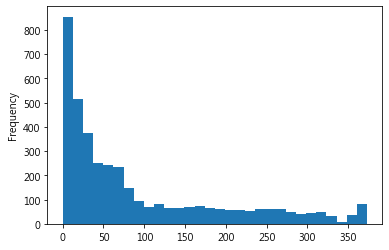

In [9]:
print(df_CLV.最近一次交易日_Recency.describe())
df_CLV.最近一次交易日_Recency.plot(kind = 'hist', bins = 30)
print(df_CLV.最近一次交易日_Recency.value_counts().head(30))

發現資料為右偏分配。眾數為 3，其他較多次數的落在 0 ~ 2、7 ~ 10、15 ~ 18。因資料分布相較於另外的 FM 兩變數不極端，每一次數都要對應較多的分配數量，故擬針對此變數分為較多的 10 組。

F: 客戶期間內購買平率，透露客戶在互動期間內對於該店家商品的需求密集程度。一樣先檢視資料狀況：

count    3950.000000
mean        3.108272
std         7.803891
min         0.005236
25%         0.142857
50%         1.131007
75%         3.022321
max       155.000000
Name: 頻率_Frequency, dtype: float64
0.500000    54
0.166667    50
0.125000    49
0.100000    48
0.142857    47
0.111111    46
0.333333    44
0.200000    44
0.071429    37
0.083333    36
0.090909    34
0.076923    34
0.250000    33
0.066667    31
0.047619    29
0.062500    27
0.052632    27
0.058824    26
0.055556    25
0.045455    25
Name: 頻率_Frequency, dtype: int64


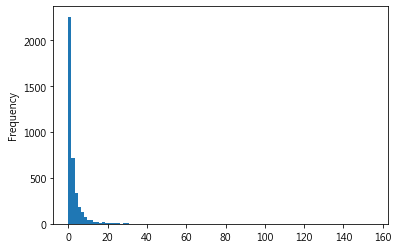

In [10]:
df_CLV.頻率_Frequency.plot(kind = 'hist', bins = 100)
print(df_CLV.頻率_Frequency.describe())
print(df_CLV[df_CLV['交易次數_NumofTranctions'] > 1]['頻率_Frequency'].value_counts().head(20))

由上可知道，此資料為右偏分配，故以眾數來了解多數資料情況。多數資料係落在 0.5，透露大多數情形，會在一天內發生多次交易。故可初步以天為單位，設計分類依據，並預計分為實務上也可以應用的五個區間

M: 該顧客總購買金額，一樣可先了解資料分布狀況：

count      3950.000000
mean       1713.385669
std        6548.608224
min       -4287.630000
25%         282.255000
50%         627.060000
75%        1521.782500
max      256438.490000
Name: 購買總金額_Total_Purchase, dtype: float64
31.0    61
11.0    58
16.0    56
15.0    48
21.0    47
17.0    46
30.0    46
22.0    46
18.0    46
14.0    45
20.0    45
38.0    44
12.0    44
33.0    43
36.0    42
32.0    42
35.0    42
25.0    41
10.0    40
19.0    40
34.0    40
29.0    39
23.0    39
13.0    37
27.0    36
24.0    35
41.0    33
26.0    32
39.0    31
28.0    31
Name: 購買總金額_Total_Purchase, dtype: int64


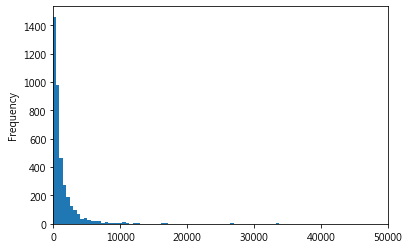

In [11]:
df_CLV.購買總金額_Total_Purchase.plot(kind = 'hist', xlim = (0, 50000), bins = 500)
print(df_CLV.購買總金額_Total_Purchase.describe())
print((df_CLV.購買總金額_Total_Purchase/10).round().value_counts().head(30)) #將購買金額以 10 為單位，觀察分布狀況

資料為右偏分配。觀察眾數，多數購買金額落在 100~400 間，故擬以 100 元為單位，並區分為實務上好處理的五個區間。

### 五、為資料給定 RMF 組別落點

In [12]:
#為 R 分組。測試是否適合全部用分位數分組；或是，除了前面較多數量分布的資料組別: 0~3, 4~10, 11~20，剩下 7 組再按照分位數位置平均分配
pd.qcut(df_CLV['最近一次交易日_Recency'], q=5, retbins = True)

(CustomerID
 12346.0    (177.0, 373.0]
 12747.0    (-0.001, 11.0]
 12748.0    (-0.001, 11.0]
 12749.0    (-0.001, 11.0]
 12820.0    (-0.001, 11.0]
                 ...      
 18280.0    (177.0, 373.0]
 18281.0    (177.0, 373.0]
 18282.0    (-0.001, 11.0]
 18283.0    (-0.001, 11.0]
 18287.0      (31.0, 70.0]
 Name: 最近一次交易日_Recency, Length: 3950, dtype: category
 Categories (5, interval[float64]): [(-0.001, 11.0] < (11.0, 31.0] < (31.0, 70.0] < (70.0, 177.0] < (177.0, 373.0]],
 array([  0.,  11.,  31.,  70., 177., 373.]))

發現按照分位數分組，結果與前述觀察結果相差不大，故可採用分位數分組；並可再依據微調間隔。

In [13]:
#參考上述落點，將分類微調為方便理解之數字
df_CLV['R_score'] = pd.cut(df_CLV.最近一次交易日_Recency, bins=[-1, 10, 30, 75, 180, 373], labels = np.arange(5, 0, -1))
df_CLV['R_score']

CustomerID
12346.0    1
12747.0    5
12748.0    5
12749.0    5
12820.0    5
          ..
18280.0    1
18281.0    2
18282.0    5
18283.0    5
18287.0    3
Name: R_score, Length: 3950, dtype: category
Categories (5, int64): [5 < 4 < 3 < 2 < 1]

labels 參考 ['近 3 日', '近 10 日', '近 20 日', '1 個月內', '1.5 個月內', '2.5 個月內', '前 3.5 個月', '前 6 個月', '前 8.5 個月', '8.5 個月以上']

In [14]:
#依樣製作 F 和 M 的分類
df_CLV['F_score'] = pd.qcut(df_CLV['頻率_Frequency'], q=5, labels = np.arange(5, 0, -1))
df_CLV['M_score'] =pd.qcut(df_CLV['購買總金額_Total_Purchase'], q=5, labels = np.arange(5, 0, -1))
df_CLV

,最近一次交易日_Recency,購買期間長度_Intervals,交易次數_NumofTranctions,頻率_Frequency,購買總金額_Total_Purchase,CLV,R_score,F_score,M_score
CustomerID,,,,,,,,,
12346.0,325,1,2,0.500000,0.00,0.00,1,4,5
12747.0,1,367,103,3.563107,4196.01,10904.10,5,2,1
12748.0,0,373,4642,0.080353,29072.10,75549.21,5,5,1
12749.0,3,210,231,0.909091,3868.20,10052.23,5,3,1
12820.0,2,324,59,5.491525,942.34,2448.84,5,1,2
...,...,...,...,...,...,...,...,...,...
18280.0,277,1,10,0.100000,180.60,469.32,1,4,5
18281.0,180,1,7,0.142857,80.82,210.03,2,4,5
18282.0,7,119,13,9.153846,176.60,458.93,5,1,5


labels 參考 ['高頻', '次高頻', '中頻', '低頻', '極低頻'] ['高購買額','次高購買額','一般購買額','低購買額', '最低購買額']

In [15]:
# 建立 RFM 類別欄
df_CLV['RFM'] = df_CLV.R_score.astype(str) + df_CLV.F_score.astype(str) + df_CLV.M_score.astype(str)
df_CLV = df_CLV.assign( RFM = df_CLV['RFM'])
df_CLV.sort_values(by = 'RFM', ascending = False).head(20)

,最近一次交易日_Recency,購買期間長度_Intervals,交易次數_NumofTranctions,頻率_Frequency,購買總金額_Total_Purchase,CLV,R_score,F_score,M_score,RFM
CustomerID,,,,,,,,,,
14578.0,2,1,24,0.041667,168.63,438.22,5,5,5,555
14087.0,2,1,70,0.014286,181.67,472.10,5,5,5,555
13428.0,9,1,74,0.013514,218.47,567.73,5,5,5,555
15904.0,7,1,30,0.033333,164.68,427.95,5,5,5,555
17359.0,10,1,15,0.066667,127.86,332.27,5,5,5,555
17383.0,3,1,51,0.019608,199.29,517.89,5,5,5,555
13436.0,1,1,12,0.083333,196.89,511.65,5,5,5,555
15540.0,10,1,15,0.066667,213.30,554.30,5,5,5,555
14204.0,1,1,44,0.022727,161.03,418.47,5,5,5,555


In [16]:
#增加 RFM 類別說明欄
R_ref = {5: '近 10 日', 4: '1 個月內', 3: '2.5 個月內', 2: '前 6 個月', 1:'前 8.5 個月'}
F_ref = {5: '高頻', 4: '次高頻', 3: '中頻', 2: '低頻', 1: '最低頻'}
M_ref = {5: '高購買額', 4: '次高購買額', 3: '一般購買額', 2: '低購買額', 1: '最低購買額'}
a = df_CLV.R_score.map(R_ref)
b = df_CLV.F_score.map(F_ref)
c = df_CLV.M_score.map(M_ref)
d = a.astype(str) +'、'+ b.astype(str) +'、'+ c.astype(str)
df_CLV = df_CLV.assign(RFM_Des = d)
df_CLV.iloc[:, -3:].sort_values(by = 'RFM_Des', ascending = False).head(20)

,M_score,RFM,RFM_Des
CustomerID,,,
15540.0,5,555,近 10 日、高頻、高購買額
15904.0,5,555,近 10 日、高頻、高購買額
13436.0,5,555,近 10 日、高頻、高購買額
18015.0,5,555,近 10 日、高頻、高購買額
17383.0,5,555,近 10 日、高頻、高購買額
14087.0,5,555,近 10 日、高頻、高購買額
14204.0,5,555,近 10 日、高頻、高購買額
13560.0,5,555,近 10 日、高頻、高購買額
17359.0,5,555,近 10 日、高頻、高購買額


In [17]:
# 了解區分出來的客群數量與大小
df_CLV[['RFM','RFM_Des']].value_counts().head(20)

RFM  RFM_Des           
531  近 10 日、中頻、最低購買額       165
145  前 8.5 個月、次高頻、高購買額     155
154  前 8.5 個月、高頻、次高購買額     131
155  前 8.5 個月、高頻、高購買額      100
521  近 10 日、低頻、最低購買額       100
431  1 個月內、中頻、最低購買額         91
313  2.5 個月內、最低頻、一般購買額      88
354  2.5 個月內、高頻、次高購買額       87
422  1 個月內、低頻、低購買額          82
541  近 10 日、次高頻、最低購買額       75
355  2.5 個月內、高頻、高購買額        68
322  2.5 個月內、低頻、低購買額        66
222  前 6 個月、低頻、低購買額         65
254  前 6 個月、高頻、次高購買額        65
331  2.5 個月內、中頻、最低購買額       60
312  2.5 個月內、最低頻、低購買額       59
421  1 個月內、低頻、最低購買額         58
345  2.5 個月內、次高頻、高購買額       58
412  1 個月內、最低頻、低購買額         57
144  前 8.5 個月、次高頻、次高購買額     57
dtype: int64

瞭解共分成了 125 群。進一步了解資料分布狀況：

count    125.0
mean      31.6
std       29.9
min        1.0
25%       11.0
50%       21.0
75%       46.0
max      165.0
dtype: float64


<AxesSubplot:ylabel='Frequency'>

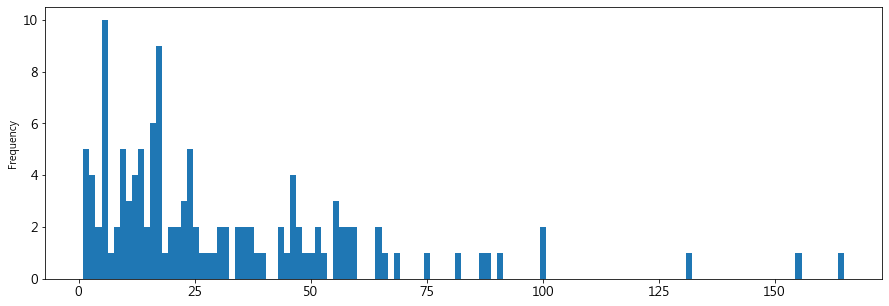

In [18]:
print(df_CLV[['RFM','RFM_Des']].value_counts().describe().round(1))
df_CLV[['RFM','RFM_Des']].value_counts().plot(kind = 'hist', bins = 125, figsize = (15,5), xlabel = '客群人數', fontsize = 13)

了解資料並未太過極端分布。故可以平均客群人數 31 人，最多人組別有 165 人，來大致了解客群狀況。

### 六、探討對於各類型客戶之經營策略：
基本上，客戶留存重於攬新客<br>
R: 越近購買，透露近期有建立關係的意願，故可頻繁溝通，並希望能深化價值理解，溝通方式可由私密性較高的下手 (服務人員親訪 > 私訊 > 電子郵件 > 社群媒體公開訊息 > 官網訊息 > 大眾新聞)；越遠購買，則可藉機打招呼，並可考慮詢問購買意見，了解未再到訪原因，如可使用電子郵件以下之私密性較低媒介，以免有過度打擾之不舒服感受。<br>
F: 期間內高頻購買者，代表其經常有需求，故應提升其購買方便性及速度，並可了解其需求原因，以尋求服務進一步改善機會；固定低頻購買者，則一樣可了解其需求環境，尋求提高其需求、提升雙方利潤之機會<br>
M: 高購買額者，顯示其需求相對仰賴該商家，故在整體利潤、折扣給予，甚至需求再度深化機會，可更加重視；低購買額者：鼓勵提高購買額，可透過積點方式。